Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("image_data/Train")
data_dir_test = pathlib.Path('image_data/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'image_data/Train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32,
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'image_data/Train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32,
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

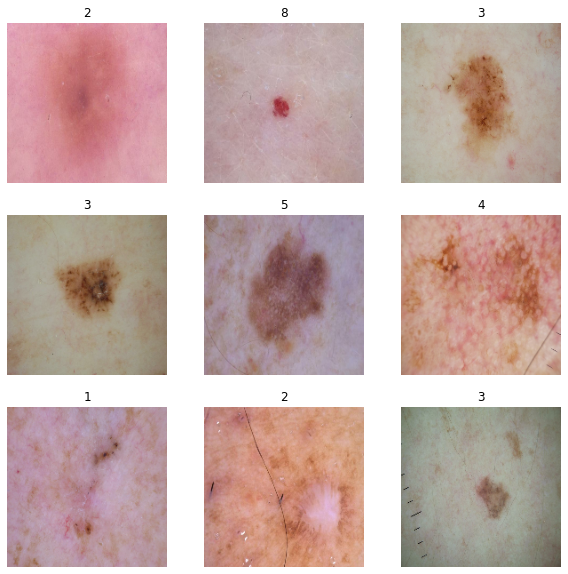

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.04511576 0.92116827


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 62s 361ms/step - loss: 1.8486 - accuracy: 0.2967 - val_loss: 1.5174 - val_accuracy: 0.4276
Epoch 2/20
169/169 [==============================] - 55s 323ms/step - loss: 1.4096 - accuracy: 0.4713 - val_loss: 1.2580 - val_accuracy: 0.5330
Epoch 3/20
169/169 [==============================] - 54s 317ms/step - loss: 1.1965 - accuracy: 0.5562 - val_loss: 1.2090 - val_accuracy: 0.5405
Epoch 4/20
169/169 [==============================] - 53s 312ms/step - loss: 0.9694 - accuracy: 0.6526 - val_loss: 1.0245 - val_accuracy: 0.6340
Epoch 5/20
169/169 [==============================] - 52s 306ms/step - loss: 0.7347 - accuracy: 0.7398 - val_loss: 0.8454 - val_accuracy: 0.6986
Epoch 6/20
169/169 [==============================] - 52s 306ms/step - loss: 0.5683 - accuracy: 0.7956 - val_loss: 0.9550 - val_accuracy: 0.6704
Epoch 7/20
169/169 [==============================] - 52s 307ms/step - loss: 0.4378 - accuracy: 0.8468 - val_loss: 0.8103 - val_ac

### Visualizing training results

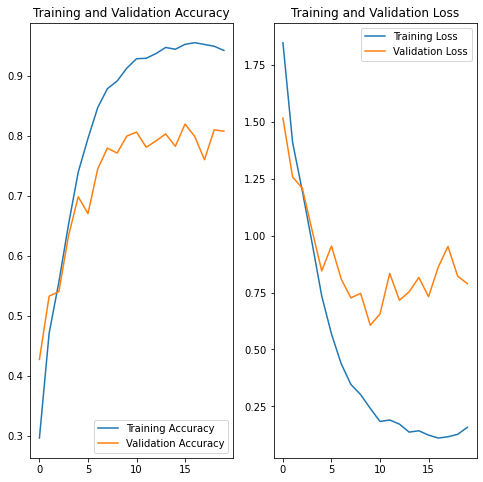

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The data seen above is overfitting as test and traing accuracy highly differ

In [18]:
# visualize how your augmentation strategy works for one instance of training image.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

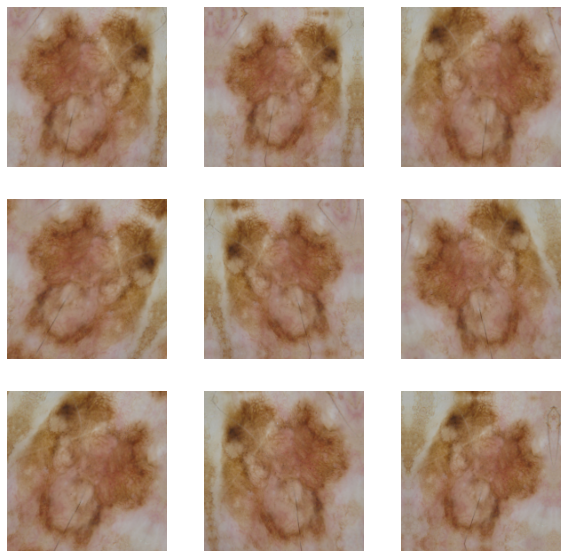

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Compiling the model with drop out and compiling and getting the summary

In [20]:
## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 58s 337ms/step - loss: 2.1944 - accuracy: 0.1387 - val_loss: 2.1151 - val_accuracy: 0.1707
Epoch 2/20
169/169 [==============================] - 57s 336ms/step - loss: 1.9303 - accuracy: 0.2654 - val_loss: 1.9192 - val_accuracy: 0.2947
Epoch 3/20
169/169 [==============================] - 58s 343ms/step - loss: 1.5952 - accuracy: 0.3973 - val_loss: 1.4127 - val_accuracy: 0.4410
Epoch 4/20
169/169 [==============================] - 59s 347ms/step - loss: 1.4851 - accuracy: 0.4171 - val_loss: 1.4229 - val_accuracy: 0.4454
Epoch 5/20
169/169 [==============================] - 59s 352ms/step - loss: 1.4336 - accuracy: 0.4431 - val_loss: 1.2995 - val_accuracy: 0.4892
Epoch 6/20
169/169 [==============================] - 59s 350ms/step - loss: 1.3619 - accuracy: 0.4733 - val_loss: 1.3630 - val_accuracy: 0.4707
Epoch 7/20
169/169 [==============================] - 59s 349ms/step - loss: 1.3471 - accuracy: 0.4813 - val_loss: 1.2389 - val_ac

### Visualizing the results

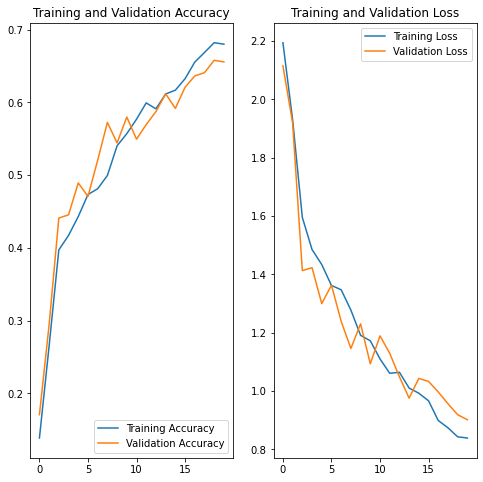

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


There is some improvement in overall accuracy and the difference of test and train accuracy has increased. 
So compared to earlier model run, it has definitely improved

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. 
This helps expose the model to more aspects of the data and generalize better.

## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? --
      seborrheic keratosis has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
       pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="image_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F7D32940>:   6%|▌         | 29/500 [00:00<00:12, 37.46 Samples/s]                  

Initialised with 114 image(s) found.
Output directory set to image_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3FA1280A0>: 100%|██████████| 500/500 [00:02<00:00, 209.60 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3FA130700>:   2%|▏         | 12/500 [00:00<00:17, 28.49 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to image_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F7B8EAC0>: 100%|██████████| 500/500 [00:02<00:00, 214.67 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3FA127610>:   5%|▌         | 27/500 [00:00<00:08, 54.89 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to image_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F670BD60>: 100%|██████████| 500/500 [00:02<00:00, 193.04 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to image_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA3F819F400>: 100%|██████████| 500/500 [00:16<00:00, 30.30 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F7BA6040>:   0%|          | 2/500 [00:00<00:26, 18.82 Samples/s]          

Initialised with 357 image(s) found.
Output directory set to image_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F7BAB700>: 100%|██████████| 500/500 [00:14<00:00, 34.34 Samples/s]                    
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F99B6FA0>:   4%|▍         | 22/500 [00:00<00:07, 59.95 Samples/s]                  

Initialised with 462 image(s) found.
Output directory set to image_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA538A3E790>: 100%|██████████| 500/500 [00:02<00:00, 187.86 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to image_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA3F81AA730>: 100%|██████████| 500/500 [00:06<00:00, 77.08 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to image_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA53A805520>: 100%|██████████| 500/500 [00:02<00:00, 175.31 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA538A259D0>:   4%|▍         | 20/500 [00:00<00:59,  8.13 Samples/s]                  

Initialised with 139 image(s) found.
Output directory set to image_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3F6582C70>: 100%|██████████| 500/500 [00:02<00:00, 176.03 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
#image_count_train = len(list(glob('*/output/*.jpg')))
#print(image_count_train)

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/output/*.jpg')))
print(image_count_test)

9000
0


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list

[PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0010240.jpg_5484af6c-1328-4f87-b832-2e015aaed8a9.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0011176.jpg_3dbea169-812a-4a7f-b67f-c0d1d08d527a.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0011125.jpg_1d813aed-81a8-4ebf-aea9-e1cd4d9a9b5e.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0010723.jpg_7565920f-2b13-45af-84d6-29bd8284bcc8.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0010503.jpg_a80fbedb-5ac0-4128-9c11-f7e45b72c371.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0000417.jpg_4af0affa-5362-4a22-9bf2-351aecb02712.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0010796.jpg_a53b71fb-cfeb-410b-a99f-a7be1c34ed12.jpg'),
 PosixPath('image_data/Train/melanoma/output/melanoma_original_ISIC_0000521.jpg_07c2e559-7531-4bd9-8db7-d359abf37839.jpg'),
 PosixPa

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

#### **Todo**: Train the model on the data created using Augmentor

In [29]:
batch_size = 32
img_height = 180
img_width = 180

## Created a new folder copied all the files with folder names into that one to get the correct representation

In [30]:
import os
import glob
import shutil
path='image_data/Train'

for fileName in os.listdir(path):
    folderPath = path + '/' + fileName
    #print(len(glob.glob(filePath+"/*")))    
    #print(filePath)
    
source_folder = 'image_data/Train'
destination_folder = 'image_data/Train_New'

# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source1 = source_folder + '/' + file_name
    destination1 = destination_folder + '/' +file_name
    if(os.path.isdir(destination1)):
        shutil.rmtree(destination1)
    os.makedirs(destination1)
    if(os.path.isdir(source1) and source1 != 'image_data/Train/.DS_Store' ):
        #print(source1)
        for file_name1 in os.listdir(source1):
            source2 = source1 + '/' + file_name1
            destination2 = destination1 + '/' + file_name1
            #os.makedirs(destination2)
            if(os.path.isfile(source2) and source1 != 'image_data/Train/.DS_Store' ):
               # print(source2)
                shutil.copy(source2, destination2)
               # print('copied', destination1)
            source3_output = source1 + '/output'
            # copy the other output files as well
            for file_name2 in os.listdir(source3_output):
                source3 = source3_output + '/' + file_name2
                destination2 = destination1 + '/' + file_name2
                #os.makedirs(destination2)
                if(os.path.isfile(source3) and source1 != 'image_data/Train/.DS_Store' ):
                    #print(source3)
                    shutil.copy(source3, destination2)
                    #print('copied', destination2)

In [31]:
data_dir_train="image_data/Train_New"
train_ds111 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [32]:
data_dir_train="image_data/Train_New"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [34]:
### Todo, choose an appropirate optimiser and loss function
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [36]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
71/71 [==============================] - 35s 482ms/step - loss: 2.0338 - accuracy: 0.2274 - val_loss: 1.6668 - val_accuracy: 0.3186
Epoch 2/30
71/71 [==============================] - 33s 463ms/step - loss: 1.6463 - accuracy: 0.3778 - val_loss: 1.4890 - val_accuracy: 0.4366
Epoch 3/30
71/71 [==============================] - 35s 492ms/step - loss: 1.4258 - accuracy: 0.4637 - val_loss: 1.2901 - val_accuracy: 0.4949
Epoch 4/30
71/71 [==============================] - 36s 500ms/step - loss: 1.3088 - accuracy: 0.5113 - val_loss: 1.1686 - val_accuracy: 0.5897
Epoch 5/30
71/71 [==============================] - 36s 495ms/step - loss: 1.1502 - accuracy: 0.5710 - val_loss: 0.9590 - val_accuracy: 0.6640
Epoch 6/30
71/71 [==============================] - 36s 508ms/step - loss: 1.0027 - accuracy: 0.6337 - val_loss: 0.8810 - val_accuracy: 0.6956
Epoch 7/30
71/71 [==============================] - 37s 510ms/step - loss: 0.8634 - accuracy: 0.6858 - val_loss: 0.8393 - val_accuracy: 0.7045

#### **Todo:**  Visualize the model results

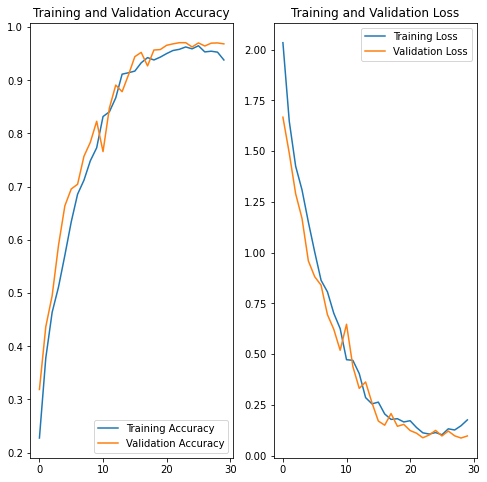

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### The results are much more accurate and rebalancing did help to remove overfitting as the training and test accuracy is almost equal and more than 95% which is good